In [33]:
import torch
import torchvision
from torch import nn

torch.__version__ , torchvision.__version__

('2.4.0+cu124', '0.19.0+cu124')

In [34]:
device = 'cuda' if torch.cuda.is_available() else "cpu"
device

'cuda'

In [35]:
def set_seeds(seed:int = 42):
    
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [36]:
set_seeds()

### Downloading the data -> 


In [37]:
import os
import zipfile
import requests
from pathlib import Path

def download_data(source:str,
                  destination:str,
                  remove_sources:bool = True) -> Path:
    
    """Downloads a dataset from source path and saves it to destination folder and then returns the path."""
    

    data_path = Path("data")
    image_path = data_path / destination
    if image_path.is_dir():
        print("Directory already exists.")
        
    else:
        image_path.mkdir(exist_ok=True, parents=True)
        
        target_file = Path(source).name
        
        with open(data_path/target_file, "wb") as f:
            request = requests.get(source)
            f.write(request.content)
            
        with zipfile.ZipFile(data_path/target_file,"r") as zip_ref:
            zip_ref.extractall(image_path)
            
        if remove_sources:
            os.remove(data_path/target_file)
            
            
    return image_path
    

In [38]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",destination="pizza_steak_sushi")

image_path

Directory already exists.


WindowsPath('data/pizza_steak_sushi')

In [39]:
train_dir = image_path/"train"
test_dir = image_path/"test"

### Creating Datasets and Dataloaders -> 

The transformation should be reproducible as well as suit the data that the model was trained on.

In [40]:
from torchvision import transforms

manual_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print(f"Manually created transform -> {manual_transform}")


Manually created transform -> Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [41]:
from Python_Modules import data_setup

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,test_dir=test_dir,transform=manual_transform,batch_size=16)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x26392fbecc0>,
 ['pizza', 'steak', 'sushi'])

In [42]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

model_effnetb0 = torchvision.models.efficientnet_b0(weights=weights).to(device)

model_effnetb0

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [43]:
automatic_transform = weights.transforms()
print(f"Automatic transforms -> {automatic_transform}")

Automatic transforms -> ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


In [44]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,test_dir=test_dir,transform=automatic_transform,batch_size=16)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x26392f805c0>,
 ['pizza', 'steak', 'sushi'])

In [45]:
for params in model_effnetb0.features.parameters():
    params.requires_grad=False
    
model_effnetb0.classifier = nn.Sequential(
    
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=3, bias=True)
)

In [46]:
from torchinfo import summary
summary(input_size=(16,3,224,224),model=model_effnetb0,col_names=["input_size","output_size","num_params","trainable"], col_width=18)

Layer (type:depth-idx)                                  Input Shape        Output Shape       Param #            Trainable
EfficientNet                                            [16, 3, 224, 224]  [16, 3]            --                 Partial
├─Sequential: 1-1                                       [16, 3, 224, 224]  [16, 1280, 7, 7]   --                 False
│    └─Conv2dNormActivation: 2-1                        [16, 3, 224, 224]  [16, 32, 112, 112] --                 False
│    │    └─Conv2d: 3-1                                 [16, 3, 224, 224]  [16, 32, 112, 112] (864)              False
│    │    └─BatchNorm2d: 3-2                            [16, 32, 112, 112] [16, 32, 112, 112] (64)               False
│    │    └─SiLU: 3-3                                   [16, 32, 112, 112] [16, 32, 112, 112] --                 --
│    └─Sequential: 2-2                                  [16, 32, 112, 112] [16, 16, 112, 112] --                 False
│    │    └─MBConv: 3-4                      

## Training a Single Model and Tracking the Results --> 

In [47]:
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model_effnetb0.parameters(), lr=0.001)

In [48]:
#Trying SummaryWriter() from TensorBoard -> 

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
writer



In [49]:
from typing import Dict, List
from tqdm.auto import tqdm

from Python_Modules.engine import train_step, test_step

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      
    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ### New: Experiment tracking ###
        # Add loss results to SummaryWriter
        writer.add_scalars(main_tag="Loss", 
                           tag_scalar_dict={"train_loss": train_loss,
                                            "test_loss": test_loss},
                           global_step=epoch)

        # Add accuracy results to SummaryWriter
        writer.add_scalars(main_tag="Accuracy", 
                           tag_scalar_dict={"train_acc": train_acc,
                                            "test_acc": test_acc}, 
                           global_step=epoch)
        
        # Track the PyTorch model architecture
        writer.add_graph(model=model, 
                         # Pass in an example input
                         input_to_model=torch.randn(32, 3, 224, 224).to(device))
    
    # Close the writer
    writer.close()
    

    # Return the filled results at the end of the epochs
    return results

c:\Users\gaura\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
#Train Model --> 

set_seeds()

results = train(model=model_effnetb0,train_dataloader=train_dataloader,test_dataloader=test_dataloader,optimizer=optimizer,loss_fn=loss_fn,epochs=10,device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0266 | train_acc: 0.4875 | test_loss: 0.7714 | test_acc: 0.8443


 10%|█         | 1/10 [00:14<02:12, 14.71s/it]

Epoch: 2 | train_loss: 0.8014 | train_acc: 0.7500 | test_loss: 0.6609 | test_acc: 0.8386


 20%|██        | 2/10 [00:28<01:53, 14.24s/it]

Epoch: 3 | train_loss: 0.6292 | train_acc: 0.8417 | test_loss: 0.5777 | test_acc: 0.8636


 30%|███       | 3/10 [00:42<01:38, 14.14s/it]

Epoch: 4 | train_loss: 0.5622 | train_acc: 0.8708 | test_loss: 0.5583 | test_acc: 0.8705


 40%|████      | 4/10 [00:56<01:23, 13.91s/it]

Epoch: 5 | train_loss: 0.5194 | train_acc: 0.8917 | test_loss: 0.5200 | test_acc: 0.8761


 50%|█████     | 5/10 [01:09<01:08, 13.74s/it]

Epoch: 6 | train_loss: 0.4585 | train_acc: 0.8708 | test_loss: 0.4479 | test_acc: 0.8818


 60%|██████    | 6/10 [01:23<00:54, 13.63s/it]

Epoch: 7 | train_loss: 0.4251 | train_acc: 0.9083 | test_loss: 0.4148 | test_acc: 0.9011


 70%|███████   | 7/10 [01:36<00:40, 13.60s/it]

Epoch: 8 | train_loss: 0.4254 | train_acc: 0.8292 | test_loss: 0.4367 | test_acc: 0.9011


 80%|████████  | 8/10 [01:49<00:27, 13.54s/it]

Epoch: 9 | train_loss: 0.3812 | train_acc: 0.8625 | test_loss: 0.4145 | test_acc: 0.8511


 90%|█████████ | 9/10 [02:03<00:13, 13.62s/it]

Epoch: 10 | train_loss: 0.3176 | train_acc: 0.9500 | test_loss: 0.3724 | test_acc: 0.8761


100%|██████████| 10/10 [02:17<00:00, 13.76s/it]


There are a few ways to see these results -> 

In [19]:
%reload_ext tensorboard

%tensorboard --logdir runs/14-09-2024

Reusing TensorBoard on port 6007 (pid 2332), started 2:02:16 ago. (Use '!kill 2332' to kill it.)

### Creating a function to prepare a SummaryWriter() instance => 

By default SummaryWriter() function saves to logdir. 

Preferably we would want one folder per experiment.

We would like to track -> 
  - Experiment Date/Timestamp 
  - Experiment Name
  - Model Name 
  - Extra info 

Our directory can be named like ---> 
**`runs/MM-DD-YYYY/experiment_name/model_name/extra`** 

In [50]:
def create_writer(experiment_name : str,
                  model_name : str,
                  extra: str = None): 
    
    from datetime import datetime
    import os
    
    timestamp = datetime.now().strftime("%d-%m-%Y")
    
    if extra:
        log_dir = os.path.join("runs",timestamp,experiment_name,model_name,extra)
    else:
        log_dir = os.path.join("runs",timestamp,experiment_name,model_name)
        
    return SummaryWriter(log_dir=log_dir)

In [51]:
example_writer = create_writer(experiment_name="data_10_percent",model_name="effnetb0",extra="5_Epochs")

print(example_writer)

In [52]:
from typing import Dict, List
from tqdm.auto import tqdm

from Python_Modules.engine import train_step, test_step

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          writer : torch.utils.tensorboard.writer.SummaryWriter = create_writer) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      
    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ### New: Experiment tracking ###
        if writer:
          # Add loss results to SummaryWriter
          writer.add_scalars(main_tag="Loss", 
                            tag_scalar_dict={"train_loss": train_loss,
                                              "test_loss": test_loss},
                            global_step=epoch)

          # Add accuracy results to SummaryWriter
          writer.add_scalars(main_tag="Accuracy", 
                            tag_scalar_dict={"train_acc": train_acc,
                                              "test_acc": test_acc}, 
                            global_step=epoch)
          
          # Track the PyTorch model architecture
          writer.add_graph(model=model, 
                          # Pass in an example input
                          input_to_model=torch.randn(32, 3, 224, 224).to(device))
      
          # Close the writer
          writer.close()
        
        else:
          pass
      

    # Return the filled results at the end of the epochs
    return results

### Setting up some modelling experiments -> 

While testing we can --> 
- Change the number of epochs 
- Change the number of hidden layers/units
- Change the amount of data(10, 20, 30...% of complete dataset)
- Change the Learning Rate
- Change the Data Augmentation
- Change the Model Architecture

#### Trying `2^3 = 8` experiments first --> 

- Model -> EffNetB0 vs B2
- Epochs -> 5 vs 10
- Dataset Size -> 10% Dataset vs 20%

**Note -> Using different training but the same testing set gives results of comparable status**

In [53]:
#Getting the 10% & 20% Traning Dataset -> 

data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",destination="pizza_steak_sushi")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",destination="pizza_steak_sushi_20_percent")

Directory already exists.
Directory already exists.


In [54]:
train_dir_10p = data_10_percent_path/"train"
test_dir_10p = data_10_percent_path/"test"
train_dir_20p = data_20_percent_path/"train"
test_dir_20p = data_20_percent_path/"test"


In [55]:
#Setting up automatic transforms to match to the pretrained models -> 

automatic_transform = weights.transforms()
automatic_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [56]:
BATCH_SIZE=16

train_dataloader_10p , test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10p,test_dir=test_dir_10p,transform=automatic_transform,batch_size=16)
train_dataloader_20p , test_dataloader_20p, class_names = data_setup.create_dataloaders(train_dir=train_dir_20p,test_dir=test_dir_20p,transform=automatic_transform,batch_size=16)

print(f"Number of batches of size {BATCH_SIZE} in 10 percent training data: {len(train_dataloader_10p)}")
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20p)}")
print(f"Number of batches of size {BATCH_SIZE} in testing data: {len(test_dataloader)}")
print(f"Number of classes: {len(class_names)}, Class names: {class_names}")

Number of batches of size 16 in 10 percent training data: 15
Number of batches of size 16 in 20 percent training data: 29
Number of batches of size 16 in testing data: 5
Number of classes: 3, Class names: ['pizza', 'steak', 'sushi']


**As we are going to use 2 models for 8 experiments, We would want to reinstantiate the model every time and not train it on an already trained previously model. Thus making 2 functions to define and create these 2 models and instantiate them would be ideal.**

In [57]:
def create_b0():
    
    weights_b0 = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    
    model_effnetb0 = torchvision.models.efficientnet_b0(weights=weights_b0).to(device)
    
    for params in model_effnetb0.features.parameters():
        params.requires_grad = False
    
    set_seeds()
    
    model_effnetb0.classifier = nn.Sequential(
        
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=1280, out_features=3, bias=True)  
    ).to(device)
    
    model_effnetb0.name="effnetb0"
    
    return model_effnetb0


In [58]:
def create_b2():
    
    weights_b2 = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    
    model_effnetb2 = torchvision.models.efficientnet_b2(weights = weights_b2).to(device)
    
    for params in model_effnetb2.features.parameters():
        params.requires_grad=False
        
    set_seeds()        
    
    model_effnetb2.classifier = nn.Sequential(
        
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=3, bias=True)
        
    ).to(device)
    
    model_effnetb0.name="effnetb2"
    
    return model_effnetb2

In [59]:
effnet0 = create_b0()

summary(input_size=(16,3,224,224),model=effnet0,col_names=["input_size","output_size","num_params","trainable"],col_width=18)

Layer (type:depth-idx)                                  Input Shape        Output Shape       Param #            Trainable
EfficientNet                                            [16, 3, 224, 224]  [16, 3]            --                 Partial
├─Sequential: 1-1                                       [16, 3, 224, 224]  [16, 1280, 7, 7]   --                 False
│    └─Conv2dNormActivation: 2-1                        [16, 3, 224, 224]  [16, 32, 112, 112] --                 False
│    │    └─Conv2d: 3-1                                 [16, 3, 224, 224]  [16, 32, 112, 112] (864)              False
│    │    └─BatchNorm2d: 3-2                            [16, 32, 112, 112] [16, 32, 112, 112] (64)               False
│    │    └─SiLU: 3-3                                   [16, 32, 112, 112] [16, 32, 112, 112] --                 --
│    └─Sequential: 2-2                                  [16, 32, 112, 112] [16, 16, 112, 112] --                 False
│    │    └─MBConv: 3-4                      

In [60]:
effnet2 = create_b2()

summary(input_size=(16,3,224,224),model=effnet2,col_names=["input_size","output_size","num_params","trainable"],col_width=18)

Layer (type:depth-idx)                                  Input Shape        Output Shape       Param #            Trainable
EfficientNet                                            [16, 3, 224, 224]  [16, 3]            --                 Partial
├─Sequential: 1-1                                       [16, 3, 224, 224]  [16, 1408, 7, 7]   --                 False
│    └─Conv2dNormActivation: 2-1                        [16, 3, 224, 224]  [16, 32, 112, 112] --                 False
│    │    └─Conv2d: 3-1                                 [16, 3, 224, 224]  [16, 32, 112, 112] (864)              False
│    │    └─BatchNorm2d: 3-2                            [16, 32, 112, 112] [16, 32, 112, 112] (64)               False
│    │    └─SiLU: 3-3                                   [16, 32, 112, 112] [16, 32, 112, 112] --                 --
│    └─Sequential: 2-2                                  [16, 32, 112, 112] [16, 16, 112, 112] --                 False
│    │    └─MBConv: 3-4                      

### Creating Experiments and Training Code ->

In [61]:
num_epochs = [5,10]

models = ["effnet0","effnet2"]

train_dataloaders = {"data_10_percent": train_dataloader_10p,
                     "data_20_percent": train_dataloader_20p}

In [32]:
from Python_Modules.utils import save_model

experiment_number=0
set_seeds()

for dataloader_name , train_dataloader in train_dataloaders.items():
    for epochs in num_epochs:
        for model_name in models:
            
            experiment_number+=1
            print(f"Model -> {model_name}")
            print(f"Experiment Number -> {experiment_number}")
            print(f"Dataloader Name -> {dataloader_name}")
            print(f"Epochs  -> {epochs}")
            

            if model_name=="effnet0":
                model=create_b0()
            else:
                model=create_b2()
            
            loss_fn = nn.CrossEntropyLoss()
            optimizer=torch.optim.Adam(params=model.parameters(),lr=0.001)
            
            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader, 
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))
            
            
            save_filepath = f"model_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")
            
        

Model -> effnet0
Experiment Number -> 1
Dataloader Name -> data_10_percent
Epochs  -> 5


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0348 | train_acc: 0.4292 | test_loss: 0.7795 | test_acc: 0.8875


 20%|██        | 1/5 [00:14<00:57, 14.42s/it]

Epoch: 2 | train_loss: 0.7785 | train_acc: 0.7583 | test_loss: 0.6784 | test_acc: 0.8943


 40%|████      | 2/5 [00:28<00:42, 14.10s/it]

Epoch: 3 | train_loss: 0.6904 | train_acc: 0.8000 | test_loss: 0.5954 | test_acc: 0.8818


 60%|██████    | 3/5 [00:41<00:27, 13.91s/it]

Epoch: 4 | train_loss: 0.5534 | train_acc: 0.7875 | test_loss: 0.5330 | test_acc: 0.8693


 80%|████████  | 4/5 [00:55<00:13, 13.76s/it]

Epoch: 5 | train_loss: 0.4702 | train_acc: 0.9167 | test_loss: 0.5067 | test_acc: 0.8386


100%|██████████| 5/5 [01:09<00:00, 13.81s/it]


[INFO] Saving model to: models\model_effnet0_data_10_percent_5_epochs.pth
--------------------------------------------------

Model -> effnet2
Experiment Number -> 2
Dataloader Name -> data_10_percent
Epochs  -> 5


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0602 | train_acc: 0.4375 | test_loss: 0.8952 | test_acc: 0.7273


 20%|██        | 1/5 [00:14<00:56, 14.21s/it]

Epoch: 2 | train_loss: 0.8027 | train_acc: 0.7208 | test_loss: 0.7440 | test_acc: 0.8455


 40%|████      | 2/5 [00:28<00:42, 14.33s/it]

Epoch: 3 | train_loss: 0.6525 | train_acc: 0.8875 | test_loss: 0.6583 | test_acc: 0.8886


 60%|██████    | 3/5 [00:42<00:28, 14.35s/it]

Epoch: 4 | train_loss: 0.5963 | train_acc: 0.8708 | test_loss: 0.6082 | test_acc: 0.8636


 80%|████████  | 4/5 [00:57<00:14, 14.45s/it]

Epoch: 5 | train_loss: 0.5096 | train_acc: 0.8667 | test_loss: 0.5454 | test_acc: 0.9250


100%|██████████| 5/5 [01:12<00:00, 14.44s/it]


[INFO] Saving model to: models\model_effnet2_data_10_percent_5_epochs.pth
--------------------------------------------------

Model -> effnet0
Experiment Number -> 3
Dataloader Name -> data_10_percent
Epochs  -> 10


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0348 | train_acc: 0.4292 | test_loss: 0.7795 | test_acc: 0.8875


 10%|█         | 1/10 [00:13<02:03, 13.78s/it]

Epoch: 2 | train_loss: 0.7785 | train_acc: 0.7583 | test_loss: 0.6784 | test_acc: 0.8943


 20%|██        | 2/10 [00:28<01:52, 14.04s/it]

Epoch: 3 | train_loss: 0.6904 | train_acc: 0.8000 | test_loss: 0.5954 | test_acc: 0.8818


 30%|███       | 3/10 [00:41<01:37, 13.93s/it]

Epoch: 4 | train_loss: 0.5534 | train_acc: 0.7875 | test_loss: 0.5330 | test_acc: 0.8693


 40%|████      | 4/10 [00:55<01:23, 13.84s/it]

Epoch: 5 | train_loss: 0.4702 | train_acc: 0.9167 | test_loss: 0.5067 | test_acc: 0.8386


 50%|█████     | 5/10 [01:09<01:08, 13.72s/it]

Epoch: 6 | train_loss: 0.4498 | train_acc: 0.9083 | test_loss: 0.4661 | test_acc: 0.8636


 60%|██████    | 6/10 [01:22<00:54, 13.67s/it]

Epoch: 7 | train_loss: 0.4160 | train_acc: 0.8625 | test_loss: 0.4405 | test_acc: 0.8886


 70%|███████   | 7/10 [01:36<00:40, 13.66s/it]

Epoch: 8 | train_loss: 0.3782 | train_acc: 0.9125 | test_loss: 0.4246 | test_acc: 0.8386


 80%|████████  | 8/10 [01:49<00:27, 13.65s/it]

Epoch: 9 | train_loss: 0.3542 | train_acc: 0.9583 | test_loss: 0.4232 | test_acc: 0.8386


 90%|█████████ | 9/10 [02:03<00:13, 13.74s/it]

Epoch: 10 | train_loss: 0.3783 | train_acc: 0.8708 | test_loss: 0.3753 | test_acc: 0.8636


100%|██████████| 10/10 [02:17<00:00, 13.73s/it]


[INFO] Saving model to: models\model_effnet0_data_10_percent_10_epochs.pth
--------------------------------------------------

Model -> effnet2
Experiment Number -> 4
Dataloader Name -> data_10_percent
Epochs  -> 10


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0602 | train_acc: 0.4375 | test_loss: 0.8952 | test_acc: 0.7273


 10%|█         | 1/10 [00:14<02:13, 14.79s/it]

Epoch: 2 | train_loss: 0.8027 | train_acc: 0.7208 | test_loss: 0.7440 | test_acc: 0.8455


 20%|██        | 2/10 [00:29<01:57, 14.74s/it]

Epoch: 3 | train_loss: 0.6525 | train_acc: 0.8875 | test_loss: 0.6583 | test_acc: 0.8886


 30%|███       | 3/10 [00:44<01:42, 14.71s/it]

Epoch: 4 | train_loss: 0.5963 | train_acc: 0.8708 | test_loss: 0.6082 | test_acc: 0.8636


 40%|████      | 4/10 [00:58<01:27, 14.56s/it]

Epoch: 5 | train_loss: 0.5096 | train_acc: 0.8667 | test_loss: 0.5454 | test_acc: 0.9250


 50%|█████     | 5/10 [01:12<01:12, 14.42s/it]

Epoch: 6 | train_loss: 0.5012 | train_acc: 0.8708 | test_loss: 0.5327 | test_acc: 0.8943


 60%|██████    | 6/10 [01:27<00:57, 14.44s/it]

Epoch: 7 | train_loss: 0.4953 | train_acc: 0.8083 | test_loss: 0.4698 | test_acc: 0.8943


 70%|███████   | 7/10 [01:41<00:43, 14.47s/it]

Epoch: 8 | train_loss: 0.4427 | train_acc: 0.8708 | test_loss: 0.4864 | test_acc: 0.8943


 80%|████████  | 8/10 [01:56<00:28, 14.43s/it]

Epoch: 9 | train_loss: 0.3779 | train_acc: 0.9333 | test_loss: 0.4504 | test_acc: 0.8818


 90%|█████████ | 9/10 [02:10<00:14, 14.50s/it]

Epoch: 10 | train_loss: 0.3765 | train_acc: 0.8875 | test_loss: 0.4502 | test_acc: 0.9250


100%|██████████| 10/10 [02:25<00:00, 14.54s/it]


[INFO] Saving model to: models\model_effnet2_data_10_percent_10_epochs.pth
--------------------------------------------------

Model -> effnet0
Experiment Number -> 5
Dataloader Name -> data_20_percent
Epochs  -> 5


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8988 | train_acc: 0.6142 | test_loss: 0.6031 | test_acc: 0.8875


 20%|██        | 1/5 [00:14<00:58, 14.74s/it]

Epoch: 2 | train_loss: 0.6121 | train_acc: 0.8233 | test_loss: 0.4714 | test_acc: 0.9318


 40%|████      | 2/5 [00:28<00:43, 14.41s/it]

Epoch: 3 | train_loss: 0.5053 | train_acc: 0.8599 | test_loss: 0.3896 | test_acc: 0.9193


 60%|██████    | 3/5 [00:43<00:28, 14.37s/it]

Epoch: 4 | train_loss: 0.4001 | train_acc: 0.8987 | test_loss: 0.3382 | test_acc: 0.9318


 80%|████████  | 4/5 [00:57<00:14, 14.26s/it]

Epoch: 5 | train_loss: 0.4283 | train_acc: 0.8578 | test_loss: 0.3239 | test_acc: 0.9318


100%|██████████| 5/5 [01:11<00:00, 14.29s/it]


[INFO] Saving model to: models\model_effnet0_data_20_percent_5_epochs.pth
--------------------------------------------------

Model -> effnet2
Experiment Number -> 6
Dataloader Name -> data_20_percent
Epochs  -> 5


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9261 | train_acc: 0.6142 | test_loss: 0.6800 | test_acc: 0.8875


 20%|██        | 1/5 [00:15<01:00, 15.03s/it]

Epoch: 2 | train_loss: 0.6422 | train_acc: 0.8319 | test_loss: 0.5540 | test_acc: 0.9375


 40%|████      | 2/5 [00:30<00:45, 15.09s/it]

Epoch: 3 | train_loss: 0.5164 | train_acc: 0.8448 | test_loss: 0.4772 | test_acc: 0.9250


 60%|██████    | 3/5 [00:45<00:30, 15.05s/it]

Epoch: 4 | train_loss: 0.4670 | train_acc: 0.8685 | test_loss: 0.4313 | test_acc: 0.9375


 80%|████████  | 4/5 [01:00<00:15, 15.02s/it]

Epoch: 5 | train_loss: 0.4098 | train_acc: 0.8922 | test_loss: 0.3742 | test_acc: 0.9375


100%|██████████| 5/5 [01:15<00:00, 15.06s/it]


[INFO] Saving model to: models\model_effnet2_data_20_percent_5_epochs.pth
--------------------------------------------------

Model -> effnet0
Experiment Number -> 7
Dataloader Name -> data_20_percent
Epochs  -> 10


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8988 | train_acc: 0.6142 | test_loss: 0.6031 | test_acc: 0.8875


 10%|█         | 1/10 [00:14<02:10, 14.50s/it]

Epoch: 2 | train_loss: 0.6121 | train_acc: 0.8233 | test_loss: 0.4714 | test_acc: 0.9318


 20%|██        | 2/10 [00:28<01:53, 14.25s/it]

Epoch: 3 | train_loss: 0.5053 | train_acc: 0.8599 | test_loss: 0.3896 | test_acc: 0.9193


 30%|███       | 3/10 [00:42<01:39, 14.19s/it]

Epoch: 4 | train_loss: 0.4001 | train_acc: 0.8987 | test_loss: 0.3382 | test_acc: 0.9318


 40%|████      | 4/10 [00:56<01:24, 14.12s/it]

Epoch: 5 | train_loss: 0.4283 | train_acc: 0.8578 | test_loss: 0.3239 | test_acc: 0.9318


 50%|█████     | 5/10 [01:10<01:10, 14.14s/it]

Epoch: 6 | train_loss: 0.3461 | train_acc: 0.8944 | test_loss: 0.3022 | test_acc: 0.9443


 60%|██████    | 6/10 [01:25<00:56, 14.18s/it]

Epoch: 7 | train_loss: 0.3564 | train_acc: 0.8858 | test_loss: 0.2931 | test_acc: 0.9443


 70%|███████   | 7/10 [01:39<00:42, 14.21s/it]

Epoch: 8 | train_loss: 0.3141 | train_acc: 0.9095 | test_loss: 0.2620 | test_acc: 0.9318


 80%|████████  | 8/10 [01:53<00:28, 14.15s/it]

Epoch: 9 | train_loss: 0.3050 | train_acc: 0.9095 | test_loss: 0.2936 | test_acc: 0.9011


 90%|█████████ | 9/10 [02:07<00:14, 14.22s/it]

Epoch: 10 | train_loss: 0.3231 | train_acc: 0.9073 | test_loss: 0.2551 | test_acc: 0.9193


100%|██████████| 10/10 [02:23<00:00, 14.37s/it]


[INFO] Saving model to: models\model_effnet0_data_20_percent_10_epochs.pth
--------------------------------------------------

Model -> effnet2
Experiment Number -> 8
Dataloader Name -> data_20_percent
Epochs  -> 10


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9261 | train_acc: 0.6142 | test_loss: 0.6800 | test_acc: 0.8875


 10%|█         | 1/10 [00:16<02:26, 16.23s/it]

Epoch: 2 | train_loss: 0.6422 | train_acc: 0.8319 | test_loss: 0.5540 | test_acc: 0.9375


 20%|██        | 2/10 [00:31<02:05, 15.73s/it]

Epoch: 3 | train_loss: 0.5164 | train_acc: 0.8448 | test_loss: 0.4772 | test_acc: 0.9250


 30%|███       | 3/10 [00:46<01:48, 15.57s/it]

Epoch: 4 | train_loss: 0.4670 | train_acc: 0.8685 | test_loss: 0.4313 | test_acc: 0.9375


 40%|████      | 4/10 [01:02<01:32, 15.38s/it]

Epoch: 5 | train_loss: 0.4098 | train_acc: 0.8922 | test_loss: 0.3742 | test_acc: 0.9375


 50%|█████     | 5/10 [01:16<01:15, 15.16s/it]

Epoch: 6 | train_loss: 0.3518 | train_acc: 0.8987 | test_loss: 0.3550 | test_acc: 0.9375


 60%|██████    | 6/10 [01:32<01:01, 15.26s/it]

Epoch: 7 | train_loss: 0.3500 | train_acc: 0.8922 | test_loss: 0.3495 | test_acc: 0.9250


 70%|███████   | 7/10 [01:47<00:45, 15.31s/it]

Epoch: 8 | train_loss: 0.3354 | train_acc: 0.8901 | test_loss: 0.3182 | test_acc: 0.9068


 80%|████████  | 8/10 [02:02<00:30, 15.21s/it]

Epoch: 9 | train_loss: 0.3214 | train_acc: 0.9224 | test_loss: 0.3262 | test_acc: 0.9375


 90%|█████████ | 9/10 [02:17<00:15, 15.14s/it]

Epoch: 10 | train_loss: 0.3722 | train_acc: 0.8513 | test_loss: 0.3081 | test_acc: 0.9375


100%|██████████| 10/10 [02:33<00:00, 15.32s/it]

[INFO] Saving model to: models\model_effnet2_data_20_percent_10_epochs.pth
--------------------------------------------------



In [71]:

%reload_ext tensorboard

%tensorboard --logdir runs/14-09-2024/ --port=6008

Opening localhost:6008 worked :)

In [72]:
#Using tensorboard.dev we can share tensorboard event files to the internet.

### **Best Performing Model ->**

The best performing model was EffnetB2 with 20% Data and 10 epochs.
General result -> More Data , More Epochs , More Param Model **∝** Model Perforamce

In [80]:
#Loading the best model -> 

best_model_path = "F:\\AI\PyTorch from FreeCodeCamp\\08_PyTorch_Experiment_Tracking\\models\model_effnet2_data_20_percent_10_epochs.pth"

best_model = create_b2()

best_model.load_state_dict(torch.load(best_model_path))


<>:3: SyntaxWarning: invalid escape sequence '\P'
<>:3: SyntaxWarning: invalid escape sequence '\P'
C:\Users\gaura\AppData\Local\Temp\ipykernel_8240\691942928.py:3: SyntaxWarning: invalid escape sequence '\P'
  best_model_path = "F:\\AI\PyTorch from FreeCodeCamp\\08_PyTorch_Experiment_Tracking\\models\model_effnet2_data_20_percent_10_epochs.pth"
C:\Users\gaura\AppData\Local\Temp\ipykernel_8240\691942928.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are e

<All keys matched successfully>

In [85]:
from pathlib import Path

effnet2_model_size = Path(best_model_path).stat().st_size//(1024*1024)
print(f"The size of the best model is {effnet2_model_size} MB")

The size of the best model is 29 MB


In [86]:
from Python_Modules.predictions import pred_and_plot_image

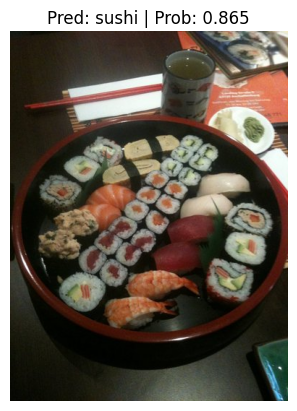

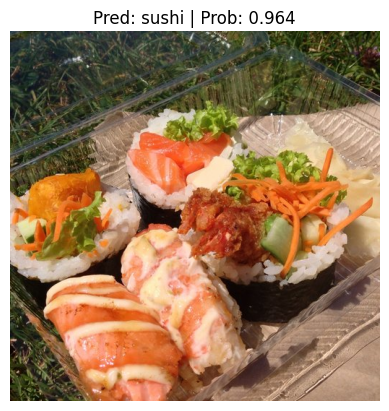

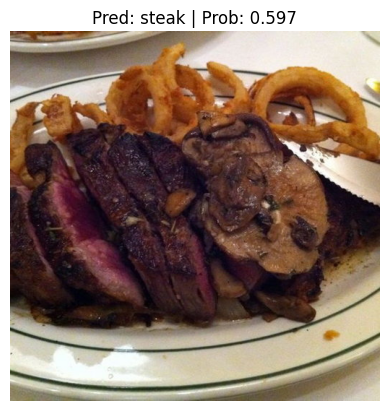

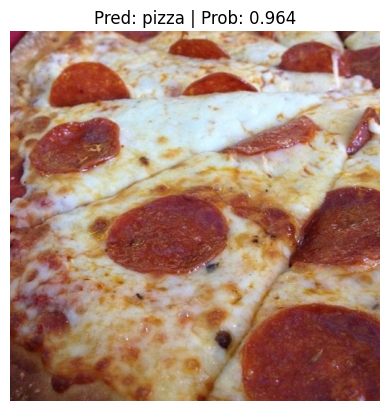

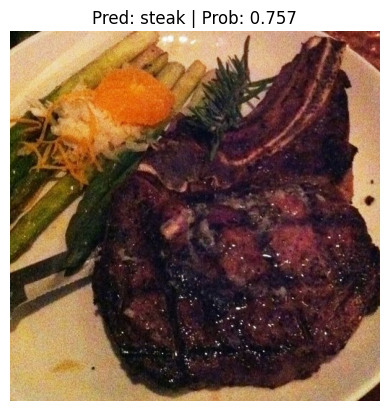

In [88]:
import random
num_images_to_plot = 5
test_image_path_list = list(Path(data_20_percent_path/"test").glob("*/*.jpg"))
test_image_path_sample = random.sample(test_image_path_list,k=num_images_to_plot)

for i in test_image_path_sample:
    pred_and_plot_image(model=best_model,class_names=class_names,image_size=(224,224),transform=automatic_transform,image_path=i)
    

### Predicting on a custom image -> 

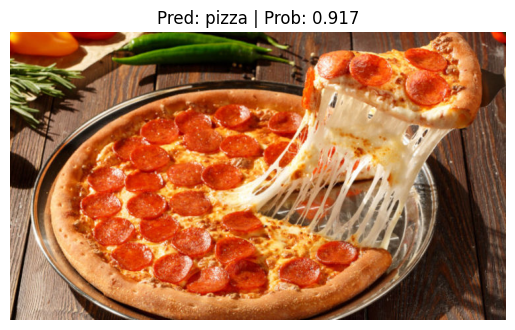

In [93]:
import requests


custom_image_path = Path("data/random_image.jpg")

if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        
        request = requests.get("https://d4t7t8y8xqo0t.cloudfront.net/resized/750X436/eazytrendz%2F4108%2Ftrend20230915051203.jpg")
        f.write(request.content)

pred_and_plot_image(model=best_model,
                    image_path=custom_image_path,
                    class_names=class_names)